In [1]:
import gzip
import os
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [2]:
X_train, y_train = load_mnist('../data', kind='train')
X_test, y_test = load_mnist('../data', kind='t10k')

In [3]:
print(X_train, X_train.shape)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] (60000, 784)


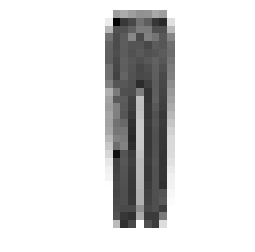

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_row = X_train[1000]
some_image = some_row.reshape(28, 28)

plt.imshow(some_image, 
           cmap=matplotlib.cm.binary, 
           interpolation='nearest')

plt.axis('off')
plt.show()

In [5]:
y_train[1000]

1

In [6]:
shuffle = np.random.permutation(60000)
X_train, y_train = X_train[shuffle], y_train[shuffle]

In [7]:
y_train_pants = (y_train == 1)
y_test_pants = (y_test == 1)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train_pants)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
sgd_model.predict([some_row])

array([ True], dtype=bool)

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_model, 
                X_train, 
                y_train_pants, 
                cv=5, 
                scoring='accuracy')

array([ 0.99216667,  0.9845    ,  0.9925    ,  0.98991667,  0.99166667])

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_predictions = cross_val_predict(sgd_model, 
                                        X_train, 
                                        y_train_pants, 
                                        cv=5)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_pants, y_train_predictions)

array([[53679,   321],
       [  270,  5730]])

In [13]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_pants, y_train_predictions))
print(recall_score(y_train_pants, y_train_predictions))

0.946950917204
0.955


In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_pants, y_train_predictions)

0.95095842668658204

In [15]:
y_scores = cross_val_predict(sgd_model,
                             X_train,
                             y_train_pants,
                             cv=5,
                             method='decision_function')

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_pants,
                                                         y_scores)

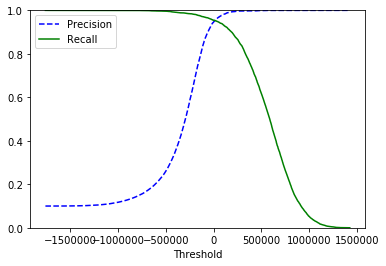

In [17]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plot_precision_recall(precisions, recalls, thresholds)
plt.show()

In [19]:
y_train_predictions_new = (y_scores > 10000)

print(precision_score(y_train_pants, y_train_predictions_new))
print(recall_score(y_train_pants, y_train_predictions_new))

0.952222407192
0.953333333333


In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_pants, y_scores)

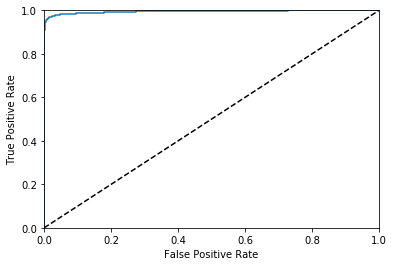

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_pants, y_scores)

0.99492766358024698

In [33]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rfc_model,
                                    X_train,
                                    y_train_pants,
                                    cv=5,
                                    method='predict_proba')

rfc_scores = y_probas_forest[:, -1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train_pants, rfc_scores)

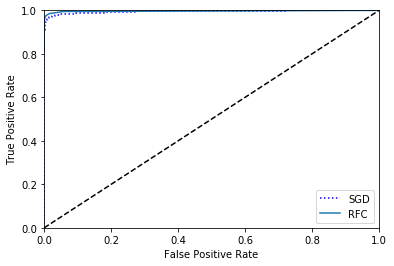

In [34]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_rfc, tpr_rfc, 'RFC')
plt.legend(loc='lower right')
plt.show()

In [35]:
roc_auc_score(y_train_pants, rfc_scores)

0.99669205864197541